## Group members
* Eryk Ptaszyński - **151950**
* Eryk Walter - **151931**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, classification_report
import shap

%matplotlib inline

/home/eryczek/.virtualenvs/decision_analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## General informantion
We have choosen Mammographic Mass dataset from the monothonic datasets suggested in a project description ([link](https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets)).

### Dataset features
The dataset is preproprecessed version orginal one from the UCI repository. The features are already represented as numbers and assuming that during preprocessing the features hadn't swapped there are:

| Variable Name | Role    | Type    | Demographic |
|---------------|---------|---------|-------------|
| BI-RADS       | Feature | Integer |             |
| Age           | Feature | Integer | Age         |  
| Shape         | Feature | Integer |             | 
| Margin        | Feature | Integer |             | 
| Density       | Feature | Integer |             | 
| Severity      | Target  | Binary  |             |

In [2]:
path = 'data/mammographic.csv'
column_names = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]
features = ["BI-RADS", "Age", "Shape", "Margin", "Density"]
target = "Severity"
data = pd.read_csv(path, names=column_names)
data.head(), data['Severity'].value_counts()

(    BI-RADS       Age     Shape  Margin   Density  Severity
 0  0.090909  0.628205  0.666667    1.00  0.666667       1.0
 1  0.090909  0.512821  1.000000    1.00  0.666667       1.0
 2  0.072727  0.128205  0.000000    0.00  0.666667       0.0
 3  0.090909  0.500000  0.000000    1.00  0.666667       1.0
 4  0.090909  0.743590  0.000000    0.75  0.666667       1.0,
 Severity
 0.0    427
 1.0    403
 Name: count, dtype: int64)

In [3]:
X = data[features]
y = (data[target]).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Explainable model
In this case it is a Logistic regression model because it is easiest to analyze.

In [4]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)
y_pred_prob = logreg_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

AUC: 0.8939
F1 Score: 0.8452
Accuracy: 0.8434

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        89
           1       0.78      0.92      0.85        77

    accuracy                           0.84       166
   macro avg       0.85      0.85      0.84       166
weighted avg       0.86      0.84      0.84       166



In [5]:
# model coeficients

logreg_model.intercept_, dict(zip(list(logreg_model.feature_names_in_), list(logreg_model.coef_[0])))

(array([-3.42067655]),
 {'BI-RADS': 1.2324790882122452,
  'Age': 3.236897294246867,
  'Shape': 1.596759206059147,
  'Margin': 1.7501197614517403,
  'Density': -0.18405844421561945})

Looking at the coeficients its clearly visible that Age has the most impact on the final class.


Explanation for instance:
BI-RADS    0.072727
Age        0.525641
Shape      0.000000
Margin     0.000000
Density    0.666667
Name: 608, dtype: float64


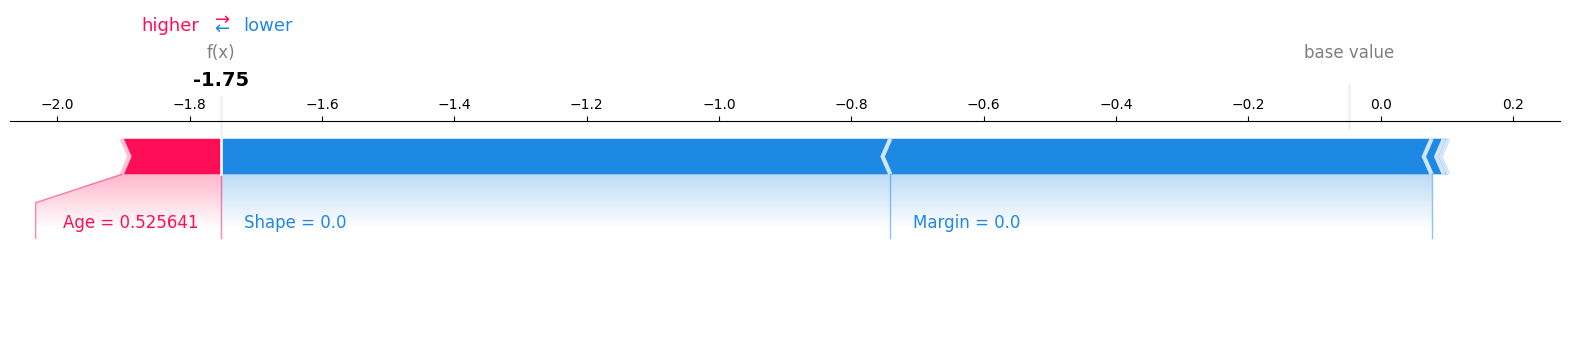


Explanation for instance:
BI-RADS    0.072727
Age        0.333333
Shape      0.333333
Margin     0.000000
Density    0.666667
Name: 457, dtype: float64


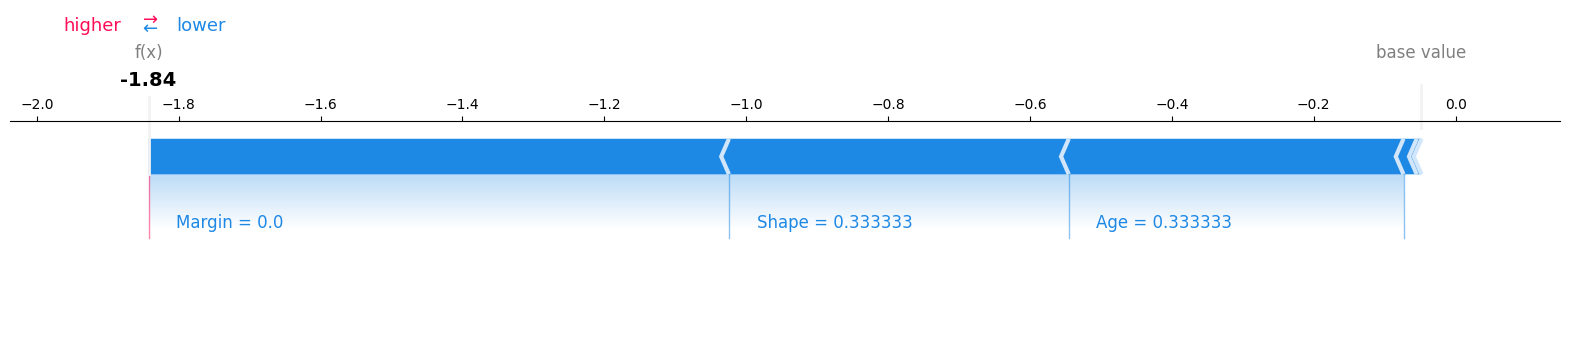


Explanation for instance:
BI-RADS    0.090909
Age        0.474359
Shape      1.000000
Margin     1.000000
Density    0.666667
Name: 290, dtype: float64


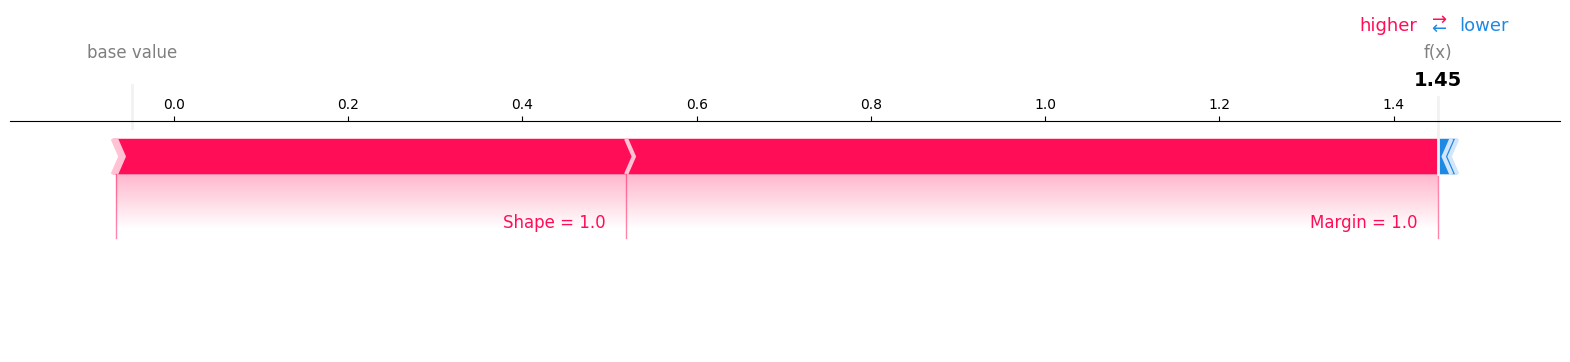

In [15]:
# Select 3 alternatives for explanation
selected_indices = [0, 1, 2]
selected_instances = X_test.iloc[selected_indices]

# SHAP values for explaining logistic regression decisions
explainer = shap.LinearExplainer(logreg_model, X_train)
shap_values = explainer.shap_values(selected_instances)

# Plot SHAP values for the selected instances
for i in range(len(selected_instances.index)):
    print(f"\nExplanation for instance:")
    print(selected_instances.iloc[i])
    shap.force_plot(explainer.expected_value, shap_values[i], selected_instances.iloc[i], matplotlib=True)

In [7]:
def min_change_to_reclassify(instance, coefficients, intercept):
    z = intercept + np.dot(coefficients, instance)
    min_changes = {}
    for i, coef in enumerate(coefficients):
        if coef != 0:
            delta = -z / coef
            min_changes[instance.index[i]] = delta
    min_change_feature = min(min_changes, key=lambda k: abs(min_changes[k]))
    min_change_value = min_changes[min_change_feature]
    return min_change_feature, min_change_value

def print_linear_equation(instance, coefficients, intercept):
    equation_parts = []
    
    for feature, coef in zip(instance.index, coefficients):
        term = f"{coef:.4f}*{instance[feature]:.4f}:{feature}"
        equation_parts.append(term)
    
    # Combine the intercept and the linear terms
    equation = f"{intercept:.4f} + " + " + ".join(equation_parts)
    
    # Print the equation
    print("Linear function equation:")
    print(f"z = {equation}")
    print(f"z = {intercept + np.dot(coefficients, instance)}")

coefficients = logreg_model.coef_[0]
intercept = logreg_model.intercept_[0]

for idx in selected_indices:
    instance = X_test.iloc[idx]
    feature, change = min_change_to_reclassify(instance, coefficients, intercept)
    print_linear_equation(instance, coefficients, intercept)
    print(f"Instance {idx}: Change {feature} by {change:.4f} to reclassify")

Linear function equation:
z = -3.4207 + 1.2325*0.0727:BI-RADS + 3.2369*0.5256:Age + 1.5968*0.0000:Shape + 1.7501*0.0000:Margin + -0.1841*0.6667:Density
z = -1.7523017997994523
Instance 0: Change Age by 0.5414 to reclassify
Linear function equation:
z = -3.4207 + 1.2325*0.0727:BI-RADS + 3.2369*0.3333:Age + 1.5968*0.3333:Shape + 1.7501*0.0000:Margin + -0.1841*0.6667:Density
z = -1.8425305082281653
Instance 1: Change Age by 0.5692 to reclassify
Linear function equation:
z = -3.4207 + 1.2325*0.0909:BI-RADS + 3.2369*0.4744:Age + 1.5968*1.0000:Shape + 1.7501*1.0000:Margin + -0.1841*0.6667:Density
z = 1.450991535449742
Instance 2: Change Age by -0.4483 to reclassify


In [8]:
def perform_space_sampling(instance, feature, change, model):
    perturbed_instance = instance.copy()
    perturbed_instance[feature] += change
    original_class = model.predict(pd.DataFrame([instance], columns=instance.index))[0]
    new_class = model.predict(pd.DataFrame([perturbed_instance], columns=perturbed_instance.index))[0]
    return original_class, new_class

feature_to_sample = 'Age'  # Replace 'feature_name' with the actual feature name
sample_range = np.linspace(-X_train[feature_to_sample].max(), X_train[feature_to_sample].max(), 15)

for idx in selected_indices:
    for change in sample_range:
        instance = X_test.iloc[idx]
        original_class, new_class = perform_space_sampling(instance, feature_to_sample, change, logreg_model)
        print(f"Instance {idx}: Original class = {original_class}, New class = {new_class}, Feature: {feature_to_sample}: + {change:.4}")
    print()

Instance 0: Original class = 0, New class = 0, Feature: Age: + -1.0
Instance 0: Original class = 0, New class = 0, Feature: Age: + -0.8571
Instance 0: Original class = 0, New class = 0, Feature: Age: + -0.7143
Instance 0: Original class = 0, New class = 0, Feature: Age: + -0.5714
Instance 0: Original class = 0, New class = 0, Feature: Age: + -0.4286
Instance 0: Original class = 0, New class = 0, Feature: Age: + -0.2857
Instance 0: Original class = 0, New class = 0, Feature: Age: + -0.1429
Instance 0: Original class = 0, New class = 0, Feature: Age: + 0.0
Instance 0: Original class = 0, New class = 0, Feature: Age: + 0.1429
Instance 0: Original class = 0, New class = 0, Feature: Age: + 0.2857
Instance 0: Original class = 0, New class = 0, Feature: Age: + 0.4286
Instance 0: Original class = 0, New class = 1, Feature: Age: + 0.5714
Instance 0: Original class = 0, New class = 1, Feature: Age: + 0.7143
Instance 0: Original class = 0, New class = 1, Feature: Age: + 0.8571
Instance 0: Origina

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Train a surrogate model
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_train, logreg_model.predict(X_train))

# Surrogate model interpretation
from sklearn.tree import export_text
print(export_text(surrogate, feature_names=list(X.columns)))

|--- Margin <= 0.12
|   |--- class: 0
|--- Margin >  0.12
|   |--- Shape <= 0.50
|   |   |--- Age <= 0.49
|   |   |   |--- class: 0
|   |   |--- Age >  0.49
|   |   |   |--- class: 1
|   |--- Shape >  0.50
|   |   |--- Age <= 0.31
|   |   |   |--- class: 1
|   |   |--- Age >  0.31
|   |   |   |--- class: 1



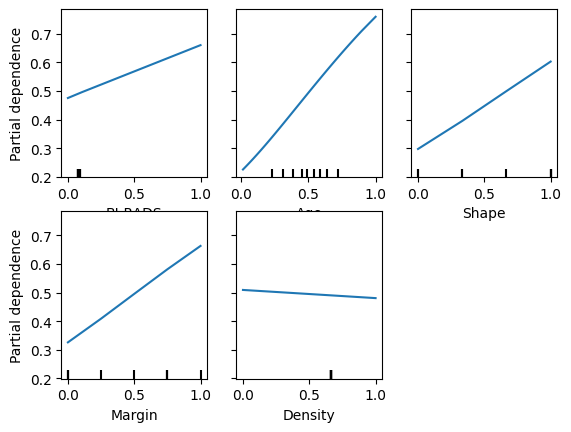

In [10]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(logreg_model, X_train, features=features)
plt.show()

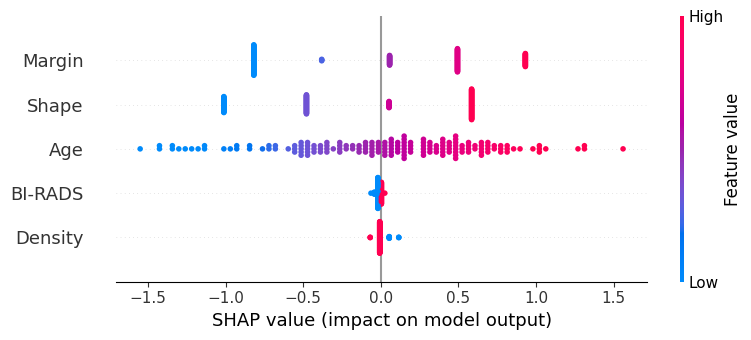

In [11]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 2.2 Interpretation of the Model

#### Based on the parameters obtained, can we say something about the user’s preferences?

Yes, the coefficients of the logistic regression model provide insight into the user's preferences. Each coefficient indicates the importance and direction of the influence of a corresponding feature on the probability of the positive class (e.g., having a certain condition).

- **BI-RADS (1.2325)**: A higher BI-RADS value increases the probability of being in the positive class. This suggests that users (or the model) consider higher BI-RADS values as indicative of higher risk.
- **Age (3.2369)**: A higher age significantly increases the probability of being in the positive class. This indicates that older age is strongly associated with the positive class, showing a preference or expectation that age is a critical factor.
- **Shape (1.5968)**: A higher shape value increases the probability of being in the positive class, indicating that certain shapes are considered more indicative of the positive class.
- **Margin (1.7501)**: A higher margin value increases the probability of being in the positive class. This suggests that larger or more irregular margins are seen as more indicative of the positive class.
- **Density (-0.1841)**: A higher density value slightly decreases the probability of being in the positive class. This indicates that higher density is somewhat associated with the negative class.

#### What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence?

- **Age** has the highest coefficient (3.2369), indicating it has the most significant influence on the classification.
- **Density** has the smallest absolute coefficient (-0.1841), indicating it has the least influence on the classification.

There are no criteria with a coefficient of exactly zero, which means that all criteria have some effect on the classification. However, the influence varies, with some having a more decisive impact than others.

#### Are there any dependencies between the criteria?

Logistic regression assumes that the features are independent of each other. However, in practice, there might be dependencies between the features. To analyze dependencies, you would typically look at interaction terms or use techniques such as SHAP interaction values. For now, we assume independence based on the logistic regression model's assumptions.

#### What is the nature of the criterion, gain, cost, non-monotonic?

- **Gain Criteria**: 
  - **BI-RADS**, **Age**, **Shape**, and **Margin** are gain criteria, as higher values increase the probability of being in the positive class.
- **Cost Criterion**: 
  - **Density** is a cost criterion, as higher values decrease the probability of being in the positive class.
- **Monotonicity**: 
  - All criteria have monotonic relationships with the probability of the positive class, meaning the relationship is consistently increasing or decreasing without changing direction.

#### Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences?

- **Preference Thresholds**: 
  - The logistic regression model uses a threshold probability (usually 0.5) to classify instances into positive or negative classes. This threshold can be adjusted based on specific needs or preferences.
- **Indifferent Evaluations**: 
  - Criteria with coefficients close to zero would be less influential, but in this model, all criteria have non-zero coefficients, so none are completely indifferent.

#### Interpret the model by at least one technique (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance)

##### Global Surrogate Model

A global surrogate model is an interpretable model that approximates the predictions of a more complex model. In this case, we can fit a decision tree to approximate the logistic regression model.

```python
from sklearn.tree import DecisionTreeClassifier, export_text

# Train a surrogate model
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_train, logreg_model.predict(X_train))

# Surrogate model interpretation
print("Global Surrogate Model (Decision Tree):")
print(export_text(surrogate, feature_names=list(X.columns)))
```

##### Partial Dependence Plot

Partial dependence plots show the relationship between a feature and the predicted outcome, marginalizing over the values of all other features.

```python
from sklearn.inspection import plot_partial_dependence

features = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']  # Example features
plot_partial_dependence(logreg_model, X_train, features, grid_resolution=50)
plt.show()
```

##### Permutation Feature Importance

Permutation feature importance measures the increase in the model's prediction error when the values of a feature are randomly shuffled. This breaks the relationship between the feature and the true outcome.

```python
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
result = permutation_importance(logreg_model, X_test, y_test, n_repeats=10, random_state=42)

# Summarize results
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{result.importances_mean[i]:.3f} "
              f" +/- {result.importances_std[i]:.3f}")
```

By using these techniques, you can interpret the logistic regression model and understand the influence of each feature on the decision-making process.